In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from tqdm import tqdm

from model import iPVAE

from dataset import PreloadedDataset



In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
device

device(type='cpu')

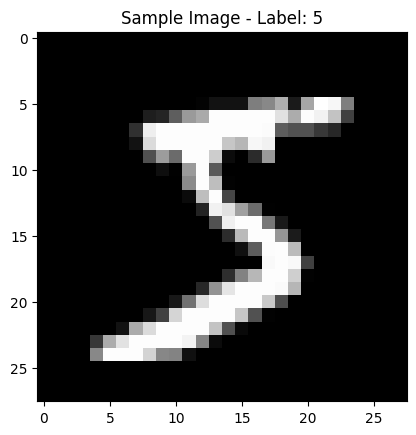

In [4]:
# Load the MNIST dataset
mnist_train = datasets.MNIST(root='../../Datasets/', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = datasets.MNIST(root='../../Datasets/', train=False, download=True, transform=torchvision.transforms.ToTensor())
train = PreloadedDataset.from_dataset(mnist_train, None, device, use_tqdm=True)
test = PreloadedDataset.from_dataset(mnist_test, None, device, use_tqdm=True)

# Display a sample image from the dataset
sample_image, sample_label = mnist_train[0]
plt.imshow(sample_image.squeeze().cpu(), cmap='gray')
plt.title(f'Sample Image - Label: {sample_label}')
plt.show()


In [5]:
train.images = train.images[:100]
train.targets = train.targets[:100]
len(train)

100

In [6]:
train.images.max(), train.images.min()

(tensor(1.), tensor(0.))

In [8]:
model = iPVAE(z_features=128, alpha=0.01, mode='mlp').to(device)
# Training script
num_epochs = 100
learning_rate = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)

losses = []
last_loss = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    num_batches = 0
    loop = tqdm(train_loader, leave=False)
    loop.set_description(f'Epoch [{epoch+1}/{num_epochs}] Loss: {last_loss:.4f}')
    for images, _ in loop:
        images = images.unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        loss = model.loss(images, steps=32)
        model.zero_grad()
        loss.backward()
        # print(f'u grad max: {model.initial_state.grad.abs().max()}')
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        # break
    # break
    
    last_loss = total_loss / num_batches
    losses.append(last_loss)

# print(f'Best loss: {min(losses)}')
plt.plot(losses)
plt.show()


RuntimeError: invalid Poisson rate, expected rate to be non-negative

In [19]:
e = torch.randn(10, 784)
model.decoder[0].weight.shape

torch.Size([1024, 128])

torch.Size([10, 784])


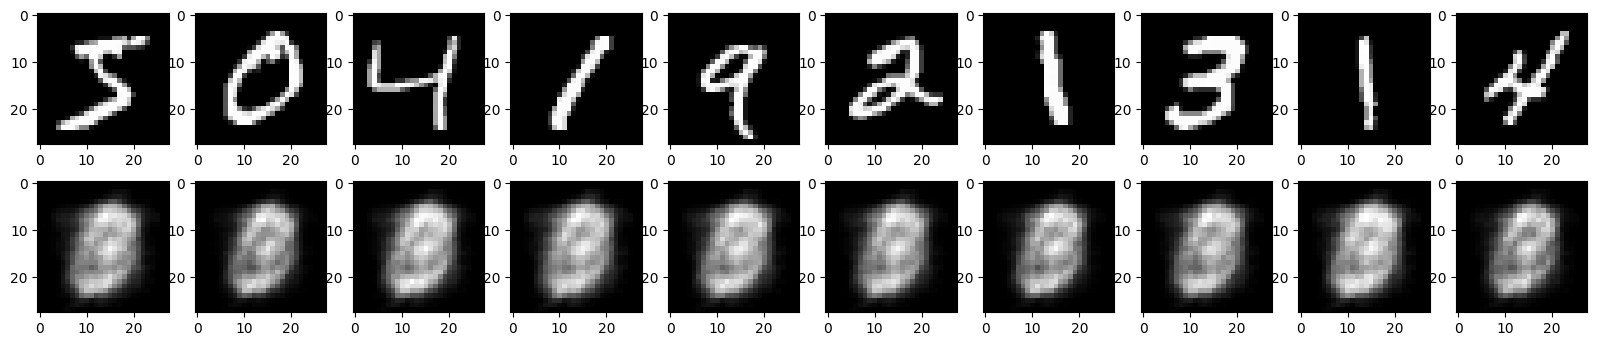

In [14]:
x = train.images[:10]
z = model(x, steps=1000)
preds = model.decoder(z)
print(preds.shape)
if preds.dim() == 2:
    preds = preds.reshape(preds.shape[0], 1, 28, 28)
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(x[i].squeeze().cpu(), cmap='gray')
    axs[1, i].imshow(preds[i].squeeze().detach().cpu(), cmap='gray')
plt.show()